## 导入

In [1]:
!pip install osm2gmns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00


In [2]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install geopandas

In [4]:
!pip install dgl==0.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.6 MB/s eta 0:00:00


In [19]:
!git clone https://github.com/argoai/argoverse-api.git

Cloning into 'argoverse-api'...
remote: Enumerating objects: 6321, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 6321 (delta 12), reused 16 (delta 9), pack-reused 6292
Receiving objects: 100% (6321/6321), 107.09 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (4247/4247), done.


In [24]:
!pip install -e ./home

ERROR: ./home is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import  pandas  as pd
from  pandas import  DataFrame as df
import numpy as np
# import skfuzzy as fuzz
# from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import math
import os
import sys
import shapely
from shapely.geometry import *

## 地图特征提取

### osmnx 读取

In [3]:
import osmnx as ox
import geopandas as gpd

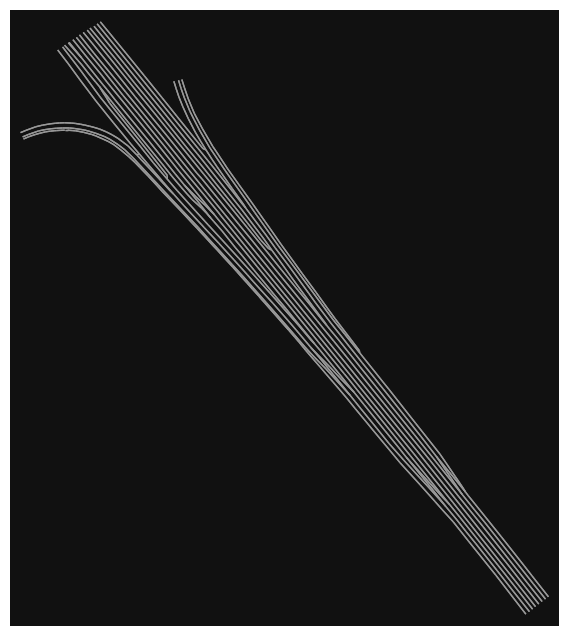

In [4]:
G = ox.graph_from_xml(r'/content/gdrive/MyDrive/exitD/lanelet2/0_cologne_butzweiler.osm', simplify=False, retain_all=True)
fig, ax = ox.plot_graph(G, node_size=0)

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

如上图, 该库解析的是车道中心线

代码整理

In [ ]:
def read_osm(file_name):
  file_path = '/content/gdrive/MyDrive/exitD/lanelet2/' + file_name
  G = ox.graph_from_xml(file_path, simplify=False, retain_all=True)
  gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
  gdf_nodes.to_csv('/content/gdrive/MyDrive/exitD/data/gdf_nodes_' + file_name.split('.')[0] + '.csv',encoding='utf-8')
  gdf_edges.to_csv('/content/gdrive/MyDrive/exitD/data/gdf_edges_' + file_name.split('.')[0] + '.csv', encoding='utf-8')

In [ ]:
# read_osm('1_cologne_fortiib.osm')
# read_osm('2_aachen_brand.osm')

### 车道向量

In [ ]:
gdf_edges.head()

osmid  oneway  reversed  length  \
u    v    key                                    
1001 1002 0     1500   False     False   5.220   
1002 1003 0     1500   False     False   9.216   
     1001 0     1500   False      True   5.220   
1003 1004 0     1500   False     False   6.314   
     1002 0     1500   False      True   9.216   

                                                      geometry  
u    v    key                                                   
1001 1002 0    LINESTRING (6.89598 50.99182, 6.89605 50.99184)  
1002 1003 0    LINESTRING (6.89605 50.99184, 6.89618 50.99187)  
     1001 0    LINESTRING (6.89605 50.99184, 6.89598 50.99182)  
1003 1004 0    LINESTRING (6.89618 50.99187, 6.89626 50.99188)  
     1002 0    LINESTRING (6.89618 50.99187, 6.89605 50.99184)

提取车道向量: lane_centerlines_dict  \\
key: lane id (int)  \\
value: lane vector ([[x0, y0],...,[xn, yn]])

In [5]:
lane_centerlines_dict = dict()  #key(lane_id), value(lane_props)

i = 0
id_list = []
for id in gdf_edges['osmid']:
  id_list.append(id)
  if id not in lane_centerlines_dict:
    lane_centerlines_dict[id] = []
  i += 1

i = 0
reverse_list = []
for r in gdf_edges['reversed']:
  reverse_list.append(r)
  i += 1

i = 0
for line in gdf_edges['geometry']:
  line = str(line)
  # print(str(line).split(' (')[2])
  x0 = float(line.split('(')[1].split(' ')[0])
  y0 = float(line.split(' ')[2].split(',')[0])
  # x1 = float(line.split(' ')[3])
  # y1 = float(line.split(' ')[4].split(')')[0])
  # print(x0,y0,x1,y1)
  id = id_list[i]
  reverse = reverse_list[i]
  if not reverse:
    lane_centerlines_dict[id].append([x0, y0])
  i += 1

print(lane_centerlines_dict[1500])

[[6.89598424975, 50.99182381446], [6.89605311001, 50.99184183871], [6.89617681551, 50.9918702498], [6.89626450394, 50.99188357803], [6.89636878849, 50.99189451978], [6.89642288942, 50.99189784402], [6.89647753698, 50.99190084242], [6.89653970057, 50.99190229781], [6.89662464792, 50.99189979963], [6.8966814437, 50.99189645885], [6.89674288565, 50.99189034851], [6.89679611298, 50.99188358668], [6.89685687906, 50.99187477873], [6.89691367447, 50.99186556357], [6.8969815388, 50.99185268748], [6.89706927839, 50.99182959558], [6.89714294985, 50.99180591463], [6.89721763068, 50.99177755239], [6.89727768921, 50.99174909465], [6.89734591638, 50.99171642022], [6.89740043214, 50.99168114918]]


### xml relation

In [6]:
import xml.etree.ElementTree as ET
# 打开XML文件
tree = ET.parse('/content/gdrive/MyDrive/exitD/lanelet2/0_cologne_butzweiler.osm')
# 获取根节点
root = tree.getroot()
ref_df = []  #id, left, right

for r in root.iter('relation'):
  # print(r.attrib)
  relation = [r.attrib['id'], "", ""]
  for mem in r[0:2]:
    # print(mem.attrib)
    # print(len(mem.attrib))
    if mem.attrib['role'] == 'left':
      relation[1] = mem.attrib['ref']
    elif mem.attrib['role'] == 'right':
      relation[2] = mem.attrib['ref']
  ref_df.append(relation)

#建立 lanlet_id 与左右车道映射
left_id_dict = dict()
right_id_dict = dict()
for i in range(len(ref_df)):
  left_id_dict[ref_df[i][0]] = ref_df[i][1]
  right_id_dict[ref_df[i][0]] = ref_df[i][2]

lane id 对应关系：

- tracks.csv 中 laneletId 对应 osm 中 relation_id
- 通过 relation_id 找到左右车道 id (left_id_dict/right_id_dict), 与 gdf_edges 中 osmid 对应

## 轨迹特征提取

Argo 数据集车分为 AV/AGENT/OTHERS \\

*   AV 为主车
*   AGENT 为需要预测的前车, 每帧仅1个AGENT
*   OTHERS 为其他车轨迹

Argo 单个轨迹csv长度为5秒、50帧 \\
参考代码取第20秒为中心, 由前20预测后30


In [43]:
total_data=pd.read_csv("/content/gdrive/MyDrive/exitD/data/00_tracks.csv")
data=df(total_data[['frame', 'trackId', 'xCenter', 'yCenter','leadId', 'leftLeadId', 'rightLeadId']])
del total_data
data.head()

<ipython-input-43-789373a9fee8>:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  total_data=pd.read_csv("/content/gdrive/MyDrive/exitD/data/00_tracks.csv")


,frame,trackId,xCenter,yCenter,leadId,leftLeadId,rightLeadId
0,0,0,380.7679,-200.3428,-1,-1,-1
1,1,0,379.9906,-199.3281,-1,-1,-1
2,2,0,379.2125,-198.3121,-1,-1,-1
3,3,0,378.4335,-197.2947,-1,-1,-1
4,4,0,377.6538,-196.2763,-1,-1,-1


In [12]:
data['frame'].unique()

array([    0,     1,     2, ..., 25398, 25399, 25400])

开始提取, 每50帧存一个csv, 每个csv选取1个agent

In [44]:
def get_traj(nums):
  i = 1
  row = 0
  while i < nums+1:
    #每50帧截取一个csv
    df = data[(data['frame'] >= row) & (data['frame'] < row+50)].reset_index()
    ids_50 = set(list(df[df['frame'] == row]['trackId'].unique())) & set(list(df[df['frame'] == (row+49)]['trackId'].unique()))
    print(ids_50)  #50帧内一直存在的车辆
    agent_id = -1  #选预测目标
    # print(df.head(3))
    for j in range(len(df)):
      # print(j)
      if df['leadId'][j] != -1 and df['trackId'][j] in ids_50:
        if df['leftLeadId'][j] != -1 and df['rightLeadId'][j] != -1:
          agent_id = df['trackId'][j]
        elif df['leftLeadId'][j] != -1:
          agent_id = df['trackId'][j]
        elif df['rightLeadId'][j] != -1:
          agent_id = df['trackId'][j]

    if agent_id != -1:
      track_df = df[['frame', 'trackId', 'xCenter', 'yCenter']]
      track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
      track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]

      for j in range(len(track_df)):
        if track_df['trackId'][j] == agent_id:
          track_df['OBJECT_TYPE'][j] = 'AGENT'

      track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
      # print(track_df.head(2))
      track_df.sort_values(by=['TIMESTAMP','TRACK_ID'],ascending=True)
      track_df.to_csv('/content/gdrive/MyDrive/exitD/data/train/' + str(i) + '.csv', index=False)
      i += 1

    row += 100


In [45]:
get_traj(250)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
{6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
{16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{16, 17, 18, 19, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
{28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}
{64, 65, 45, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{64, 65, 66, 67, 68, 69, 70, 71, 72, 58, 59, 60, 61, 62, 63}
{58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{59, 60, 62, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85}
{67, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95}
{80, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{86, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110}
{98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117}
{100, 101, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{106, 107, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120}
{112, 114, 118, 119, 120, 121, 122, 123, 124}
{128, 129, 120, 121, 122, 123, 124, 125, 126, 127}
{128, 129, 130, 131, 132, 133, 134, 135, 122, 123, 124, 125, 126, 127}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 123, 126, 127}
{128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145}
{134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151}
{145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157}
{160, 161, 162, 163, 164, 145, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159}
{160, 161, 162, 163, 164, 165, 166, 167, 168, 151, 152, 153, 154, 155, 156, 157, 158, 159}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{152, 153, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174}
{158, 160, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181}
{168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{192, 173, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191}
{192, 193, 194, 195, 196, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191}
{192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 182, 186, 187, 190, 191}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 191}
{191, 192, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217}
{198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221}


<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'][j] = 'AGENT'
<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

{203, 207, 208, 210, 211, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227}
{224, 225, 226, 227, 228, 229, 230, 231, 210, 217, 218, 219, 220, 221, 222, 223}
{224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 219, 222}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241}
{230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246}
{256, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{256, 257, 258, 259, 237, 239, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
{256, 257, 258, 259, 260, 261, 262, 263, 264, 245, 247, 249, 250, 251, 252, 253, 254, 255}
{256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 251}


<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'][j] = 'AGENT'
<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

{260, 261, 263, 264, 265, 266, 267, 268, 269, 270}
{263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276}
{268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281}
{271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{288, 289, 273, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287}
{273, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296}
{281, 283, 284, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{284, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308}
{290, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311}
{299, 302, 303, 305, 306, 307, 308, 309, 310, 311, 312, 313}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{306, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318}
{320, 321, 322, 323, 324, 309, 311, 312, 313, 314, 315, 316, 317, 318, 319}
{320, 321, 322, 323, 324, 325, 326, 327, 312, 313, 314, 315, 316, 317, 318, 319}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{317, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339}
{321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345}
{326, 327, 328, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{332, 337, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358}
{343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366}
{349, 350, 351, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{351, 355, 357, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377}
{357, 359, 362, 363, 366, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381}
{372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{384, 385, 386, 387, 388, 375, 378, 379, 380, 381, 382, 383}
{384, 385, 386, 387, 388, 389, 380, 381, 382, 383}
{384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 383}
{386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{386, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403}
{393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414}
{396, 397, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{401, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422}
{416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 409, 410, 411, 412, 415}
{416, 417, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 415}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{421, 422, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434}
{426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437}
{433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443}
{448, 449, 450, 451, 452, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447}


<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'][j] = 'AGENT'
<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

{436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458}
{438, 440, 441, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470}
{446, 448, 449, 450, 451, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484}
{461, 462, 463, 465, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496}


<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

{476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504}
{482, 484, 487, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505}
{484, 489, 494, 495, 496, 497, 498, 499, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{512, 513, 514, 515, 516, 497, 502, 503, 505, 506, 507, 508, 509, 510, 511}
{512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 506, 507, 508, 509, 510, 511}
{512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{515, 516, 519, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538}
{522, 524, 528, 531, 532, 533, 534, 535, 536, 537, 538, 539}
{531, 533, 535, 536, 537, 538, 539, 540, 541, 542}
{544, 545, 546, 547, 548, 549, 550, 535, 539, 540, 541, 542, 543}
{540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558}
{542, 543, 545, 546, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{548, 550, 551, 552, 553, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570}
{557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571}
{576, 567, 569, 570, 571, 572, 573, 574, 575}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{576, 577, 578, 579, 580, 571, 572, 573, 574, 575}
{576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 573, 574, 575}
{577, 579, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{581, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597}
{583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600}
{586, 588, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{608, 609, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607}
{608, 609, 610, 611, 599, 600, 601, 602, 604, 605, 606, 607}
{608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 606, 607}
{609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 606}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624}
{618, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630}
{621, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636}
{640, 641, 642, 643, 644, 645, 646, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639}
{640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 636, 637, 639}
{640, 643, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{652, 653, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668}
{653, 656, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675}
{661, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{663, 665, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685}
{675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 671}
{681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703}
{687, 688, 689, 690, 691, 692, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707}
{690, 694, 698, 699, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{699, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725}
{706, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732}


<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

{711, 712, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739}
{711, 712, 714, 718, 721, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744}
{736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 727, 729, 731, 733, 734, 735}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{738, 739, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 733}
{742, 743, 744, 746, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761}
{750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{750, 753, 754, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766}
{760, 761, 762, 763, 764, 765, 766, 767}
{768, 769, 770, 771, 772, 773, 763, 765, 766, 767}
{768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 767}


<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

{768, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782}
{770, 774, 775, 776, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787}
{779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{781, 782, 783, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795}
{787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{800, 801, 802, 803, 804, 794, 795, 796, 797, 798, 799}
{800, 801, 802, 803, 804, 805, 806, 807, 796, 797, 798, 799}
{800, 802, 803, 804, 805, 806, 807, 808, 796}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{804, 806, 807, 808, 809, 810, 811}
{806, 808, 809, 810, 811, 812, 813, 814}
{809, 810, 811, 812, 813, 814, 815, 816}
{812, 813, 814, 815, 816, 817, 818, 819, 820}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{812, 813, 814, 816, 817, 818, 819, 820, 821, 822, 823}
{816, 818, 819, 820, 821, 822, 823, 824}
{821, 822, 823, 824, 825, 826, 827, 828, 829}


<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

{832, 833, 834, 835, 836, 837, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831}
{824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{828, 830, 831, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851}
{834, 836, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{841, 843, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859}
{864, 865, 866, 867, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{855, 856, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876}
{859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{861, 864, 865, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886}
{871, 872, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{896, 897, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895}
{896, 897, 898, 899, 900, 901, 902, 889, 890, 891, 892, 893, 894, 895}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 889, 891, 892, 893, 894, 895}
{898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{904, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916}
{908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{910, 911, 912, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931}
{914, 916, 917, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{924, 925, 926, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945}
{928, 931, 932, 934, 935, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{935, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965}
{942, 943, 944, 945, 947, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{949, 950, 952, 953, 955, 956, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977}
{958, 960, 962, 963, 965, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{968, 969, 971, 972, 973, 974, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995}
{972, 974, 976, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{978, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005}
{993, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 988, 991}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{993, 998, 1000, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 991}
{1000, 1005, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022}
{1024, 1025, 1026, 1027, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023}
{1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1021}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1021}
{1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053}
{1056, 1037, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055}


<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'][j] = 'AGENT'
<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

{1056, 1057, 1058, 1059, 1060, 1061, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055}
{1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1054, 1055}
{1054, 1055, 1056, 1057, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082}
{1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088}
{1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093}


<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'][j] = 'AGENT'
<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

{1076, 1078, 1079, 1080, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097}
{1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1082, 1084, 1087}
{1089, 1090, 1092, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110}


<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'][j] = 'AGENT'
<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

{1094, 1096, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117}
{1098, 1099, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122}
{1108, 1109, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1114, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134}
{1119, 1123, 1124, 1125, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141}
{1125, 1127, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1152, 1153, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151}
{1152, 1153, 1154, 1155, 1156, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151}
{1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1144, 1147, 1148, 1149, 1150, 1151}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1149}
{1156, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176}
{1162, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1184, 1185, 1166, 1168, 1169, 1170, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183}
{1184, 1185, 1186, 1187, 1188, 1189, 1190, 1173, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183}
{1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1173, 1175, 1181, 1183}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1183}
{1187, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210}
{1194, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214}


<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

{1196, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218}
{1216, 1217, 1218, 1219, 1220, 1201, 1203, 1206, 1208, 1210, 1211, 1212, 1213, 1214, 1215}
{1216, 1217, 1218, 1219, 1220, 1221, 1222, 1210, 1212, 1213, 1215}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1215}
{1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228}
{1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235}
{1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237}


<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

{1229, 1230, 1231, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241}
{1248, 1249, 1250, 1251, 1252, 1233, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247}
{1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1243, 1244, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268}
{1249, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279}
{1280, 1281, 1282, 1283, 1284, 1263, 1264, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279}
{1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1273, 1274, 1275, 1276, 1277, 1278, 1279}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1276, 1278, 1279}
{1282, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306}
{1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1294, 1295, 1296, 1297, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316}
{1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1301, 1303, 1304, 1306, 1308, 1309, 1311}
{1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331}
{1320, 1321, 1322, 1323, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336}
{1344, 1327, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350}
{1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1334, 1338, 1339, 1340, 1341, 1342, 1343}
{1344, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1341}


<ipython-input-44-5e8b42a4b733>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df.rename(columns={"frame":"TIMESTAMP", "trackId":"TRACK_ID", "xCenter":"X", "yCenter":"Y"}, inplace=True)
<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

{1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359}
{1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361}
{1353, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

{1357, 1358, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373}
{1376, 1377, 1378, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375}


<ipython-input-44-5e8b42a4b733>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['OBJECT_TYPE'] = ['OTHER' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_df['CITY_NAME'] = ['butz' for i in range(len(track_df))]
<ipython-input-44-5e8b42a4b733>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [ ]:
# track_df.sort_values(by='frame',ascending=True)
# track_df.head()

,frame,trackId,xCenter,yCenter,type
0,0,0,380.7679,-200.3428,OTHER
1,1,0,379.9906,-199.3281,OTHER
2,2,0,379.2125,-198.3121,OTHER
3,3,0,378.4335,-197.2947,OTHER
4,4,0,377.6538,-196.2763,OTHER


### 车道对应

In [7]:
total_data=pd.read_csv("/content/gdrive/MyDrive/exitD/data/00_tracks.csv")
data=df(total_data[['frame', 'trackId', 'laneletId']])
del total_data
data.head()

<ipython-input-7-aa4e7783e9a8>:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  total_data=pd.read_csv("/content/gdrive/MyDrive/exitD/data/00_tracks.csv")


,frame,trackId,laneletId
0,0,0,1696
1,1,0,1696
2,2,0,1696
3,3,0,1696
4,4,0,1696


In [8]:
agent_lane_dict = dict()
for id in list(data['trackId'].unique()):
  lanes = list(data[data['trackId']==1]['laneletId'].unique())
  agent_lane_dict[id] = list()
  for lane in lanes:
    if len(lane) > 5:
      agent_lane_dict[id].append(lane.split(';')[0])
      agent_lane_dict[id].append(lane.split(';')[1])
    else:
      agent_lane_dict[id].append(lane)

print(agent_lane_dict[1])

['1707', '1710', '1959']


In [ ]:
# data[data['trackId']==2]['laneletId'].unique()

array(['1903', '1907', '1907;1910', '1673', '1676'], dtype=object)

## DataSet

In [9]:
import sys
sys.path.append('/content/argoverse-api/')

In [10]:
import torch
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from torch.utils.data import DataLoader,Dataset
# from argoverse.map_representation.map_api import ArgoverseMap
import dgl
import numpy as np
import os
from pathlib import Path

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [51]:
max_nodes = 30
max_lanes = 10

### get_lane_centerlines

In [52]:
def get_lane_centerlines(argoverse_data, lane_centerlines_dict):
  '''
  根据车辆位置信息和地图，获取周围的车道信息
  Args:
    argoverse_data: afl, 获取车辆轨迹, 包含车道id, traj_xy
  return:
    lane_centerlines: list [[]]
  '''
  agent_obs_traj = argoverse_data.agent_traj
  track_id = int(argoverse_data.seq_df[argoverse_data.seq_df["OBJECT_TYPE"] == "AGENT"]["TRACK_ID"].unique()[0])
  lane_centerlines_id = agent_lane_dict[track_id]
  # for id in data['laneletId']:
  #   if len(id) < 6:
  #     lane_centerlines_id.add(id)
  #   else:
  #     ids = id.split(';')
  #     lane_centerlines_id.add(id[0])
  #     lane_centerlines_id.add(id[1])

  lane_centerlines = []
  for id in lane_centerlines_id:
    if id in left_id_dict:
      left_id = left_id_dict[id]
      lane_centerlines.append(lane_centerlines_dict[int(left_id)])
    if id in right_id_dict:
      right_id = right_id_dict[id]
      lane_centerlines.append(lane_centerlines_dict[int(right_id)])

  return lane_centerlines


In [ ]:
#test
# root = '/content/gdrive/MyDrive/exitD/data/train'
# afl = ArgoverseForecastingLoader(root)
# lane_centerlines = get_lane_centerlines(afl[1], lane_centerlines_dict)
# print(lane_centerlines)

[[[6.89938212144, 50.99075813272]], [[6.89941853396, 50.99077624265], [6.89926977773, 50.99090212924]], [[6.89909004362, 50.991007318], [6.89920523155, 50.99090633918]], [[6.89924489385, 50.99092316461], [6.89894624127, 50.99118834355]], [[6.89883298848, 50.99122289416], [6.89881146793, 50.99124600384], [6.89873945707, 50.99130949287], [6.89866109178, 50.99137823845]], [[6.89887914996, 50.99124890013]]]


### compose_graph

In [53]:
def compose_graph(lane,label):
    '''
    输入的是车道向量
    把车道组织成图,并返回结点特征((x1,y1),(x2,y2),label)
    Args:
    lane: list, 车道中心线向量
    label: int, 车辆周围车道编号
    '''
    nodeN = lane.shape[0]-1
    #features = torch.zeros(nodeN,5)
    features = torch.zeros(max_nodes,5)
    graph = dgl.DGLGraph()
    #graph.add_nodes(nodeN)
    graph.add_nodes(max_nodes)
    mask = []
    for i in range(max_nodes):
        if i < nodeN:
            features[i][0] = lane[i][0]
            features[i][1] = lane[i][1]
            features[i][2] = lane[i+1][0]
            features[i][3] = lane[i+1][1]
            features[i][4] = label#torch.tensor(list(lane[i])+list(lane[i+1])+[label])
            mask.append(1)
        else:
            mask.append(0)

    src = []
    dst = []
    for i in range(nodeN):
        for j in range(nodeN):
            if i != j:
                src.append(i)
                dst.append(j)
    graph.add_edges(src,dst)
    graph.ndata['v_feature'] = features
    return graph,features


### collate

In [54]:
def collate(samples):
    datas,labels = map(list,zip(*samples))
    AgentGraph = [data['Agent'] for data in datas]
    Center = [data['centerAgent'] for data in datas]
    Mask = [data['Mapmask'] for data in datas]
    batched_graph = dgl.batch(AgentGraph)
    map_set = []
    feature_set = []
    for index in range(max_lanes):
        map_batch = []
        for data in datas:
            map_batch.append(data['Map'][index])
        mgraph = dgl.batch(map_batch)
        map_set.append(mgraph)
        feature_set.append(mgraph.ndata['v_feature'])

#     for data in datas:
#         for i in range(len(data['Map'])):
#             map_set.append(data['Map'][i])
#             feature_set.append(data['Mapfeature'][i])
    new_data = {}
    new_data['Map'] = map_set
    new_data['Mapfeature'] = torch.stack(feature_set,dim = 0)
    new_data['Agent'] = batched_graph
    new_data['Agentfeature'] = batched_graph.ndata['v_feature']
    new_data['centerAgent'] = Center
    new_data['Mapmask'] = torch.stack(Mask,dim = 0)
    #new_label = []
    #for l in labels:
        #new_label += list(l.flatten())
    return new_data,torch.stack(labels,dim = 0).reshape(-1,60)

### VectorNetDataset

In [15]:
from pathlib import Path

In [ ]:
#test
# root = '/content/gdrive/MyDrive/exitD/data/train/'
# afl = ArgoverseForecastingLoader(root)
# afl[2].agent_traj[0:5]

array([[ 575.2726, -448.3358],
       [ 574.6869, -447.562 ],
       [ 574.101 , -446.7881],
       [ 573.5149, -446.0143],
       [ 572.9285, -445.2404]])

VectorNet 仅取 type=AGENT 的轨迹和地图数据进行训练

In [16]:
class VectorNetDataset(Dataset):
    '''
    VectorNet数据集
    '''
    def __init__(self, root,train = True,test = False):
        '''
        根据路径获得数据，并根据训练、验证、测试划分数据
        train_data 和 test_data路径分开
        '''
        self.test = test
        self.train = train
        self.afl = ArgoverseForecastingLoader(root)
        # self.avm = ArgoverseMap()
        root_dir = Path(root)
        r = [(root_dir / x).absolute() for x in os.listdir(root_dir)]
        n = len(r)

        if self.test == True:
            self.start = 0
            self.end = n
        elif self.train:
            self.start = 0
            self.end = int(0.7*n)
        else:
            self.start = int(0.7*n)+1
            self.end = n

    def __getitem__(self,index):
        '''
        从csv创建图输入模型
        '''
        data = {}
        # agent_data = pd.read_csv(self.root_dir)
        lane_centerlines = get_lane_centerlines(self.afl[self.start+index], lane_centerlines_dict)
        agent_obs_traj = self.afl[index].agent_traj
        data['centerAgent'] = agent_obs_traj[19]

        #把车道组织成向量和图
        map_set = []
        map_feature = []
        map_mask = []
        x_min = min(agent_obs_traj[:,0])
        x_max = max(agent_obs_traj[:,0])
        y_min = min(agent_obs_traj[:,1])
        y_max = max(agent_obs_traj[:,1])#进行norm
        for lane in lane_centerlines:
            lane = (lane - agent_obs_traj[19])/np.array([x_max-x_min,y_max-y_min])
            graph,features = compose_graph(lane,len(map_set))
            map_set.append(graph)
            map_feature.append(features)
            map_mask.append(1)
        if len(map_set) < max_lanes:
            while(len(map_set) < max_lanes):
                #形成空的图，保证大小一致
                lane = np.array([[0,0]])
                graph,features = compose_graph(lane,0)
                map_set.append(graph)
                map_feature.append(features)
                map_mask.append(0)
        else:
            raise Exception("the max lanes is not enough:",len(map_set))
        agent_obs_traj_norm = (agent_obs_traj - agent_obs_traj[19])/np.array([x_max-x_min,y_max-y_min])
        graph,features = compose_graph(agent_obs_traj_norm[:20],len(map_set))
        data['Map'] = map_set
        data['Mapfeature'] = map_feature
        data['Agent'] = graph
        data['Agentfeature'] = features
        data['Mapmask'] = torch.Tensor(map_mask)
        label = []
        for i in range(19,49):
            label.append(torch.Tensor(agent_obs_traj_norm[i+1]-agent_obs_traj_norm[i]))
            #label = agent_obs_traj_norm[20:50]
            #以dx,dy作为特征  # 60
        label = torch.stack(label,dim = 0)
        return data,label.flatten()

    def __len__(self):
        return self.end - self.start


## Model

模型架构部分

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
torch.set_default_tensor_type(torch.FloatTensor)

### MLP

In [18]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(MLP,self).__init__()
        self.MLP = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU()
        )

    def forward(self,x):
        output = self.MLP(x)
        return output

### GCN

$\varphi_{agg}$: 池化, 这里取最大值

In [ ]:
!pip show dgl

Name: dgl
Version: 0.9.1
Summary: Deep Graph Library
Home-page: https://github.com/dmlc/dgl
Author: 
Author-email: 
License: APACHE
Location: /usr/local/lib/python3.10/dist-packages
Requires: networkx, numpy, psutil, requests, scipy, tqdm
Required-by: 


In [19]:
import dgl
def gcn_reduce(nodes):
    #agg_feature = torch.max(nodes.mailbox['msg'], dim=1)
    return {'v_feature': torch.max(nodes.mailbox['msg'], dim=1)[0]} #rel agg

In [20]:
class GCNLayer(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GCNLayer,self).__init__()

    def forward(self,g,inputs):
        gcn_message = dgl.function.copy_src('v_feature','msg') ###
        g.ndata['v_feature'] = inputs
        # g.send(g.edges(),gcn_message)
        # g.recv(g.nodes(),gcn_reduce)
        g.update_all(gcn_message,gcn_reduce)
        v_feature = g.ndata.pop('v_feature')
        return torch.cat([inputs,v_feature],dim = 1) #rel: concate

### subgraph

In [21]:
#Subgraph
class SubNetwork(nn.Module):
    def __init__(self,in_feats,hidden_size,layernums):
        super(SubNetwork,self).__init__()
        self.encoder = []
        self.gcnlayer = []
        self.layernums = layernums
        input_size = in_feats
        for i in range(0,layernums):
            if i == 0:
                self.encoder.append(MLP(input_size, hidden_size))
            else:
                self.encoder.append(MLP(hidden_size*2, hidden_size))  #2
            self.gcnlayer.append(GCNLayer(hidden_size, hidden_size*2)) #2

    def forward(self,g,inputs):
        g.ndata['v_feature'] = inputs
        g_batch = g
        for i in range(self.layernums):
            g_list = dgl.unbatch(g_batch)
            #进入MLP需要unbatch
            for subg in g_list:
                v_feature = self.encoder[i](subg.ndata['v_feature'])  #node encoder
                subg.ndata['v_feature'] = v_feature
            #进入gcn可以batch回来
            g_batch = dgl.batch(g_list)
            v_feature = self.gcnlayer[i](g_batch,g_batch.ndata['v_feature'])  #gcn
            g_batch.ndata['v_feature'] = v_feature
        g_list = dgl.unbatch(g_batch)
        v_feature = []
        for subg in g_list:
            v_feature.append(subg.ndata['v_feature'])
        return torch.stack(v_feature,0)

### attention

In [22]:
class SelfAttention(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(SelfAttention, self).__init__()
        self.wq = torch.nn.Parameter(torch.randn(in_dim,out_dim))
        self.wk = torch.nn.Parameter(torch.randn(in_dim,out_dim))
        self.wv = torch.nn.Parameter(torch.randn(in_dim,out_dim))

    def forward(self,input_feature):
        WQ = input_feature.mm(self.wq)
        WK = input_feature.mm(self.wk)
        WV = input_feature.mm(self.wv)
        QK = WQ.mm(WK.T)
        QK = F.softmax(QK,dim = 1)
        V = QK.mm(WV)
        return V

### GAT
Global attention graph  \\
建模 polyline node features 间高阶交互

In [23]:
class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = None #don't define the g before
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)  #aggregate
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h }

    def forward(self, g,h):
        self.g = g
        # equation (1) encoder polyline
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2) aggregate
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)  GNN
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

### VectorNet


In [46]:
#VectorNet model
class VectorNet(nn.Module):
    '''
    调用此模型即可
    '''
    def __init__(self,in_dim,hidden_size,out_dim):
        super(VectorNet,self).__init__()
        self.subMapNetwork = SubNetwork(in_dim,hidden_size,3)
        self.subAgentNetwork = SubNetwork(in_dim,hidden_size,3)
        self.GlobalNetwork = SelfAttention(hidden_size*2,hidden_size*2) #GATLayer(hidden_size*2,hidden_size*2)
        self.MLP = nn.Sequential(
            nn.Linear(hidden_size*2,hidden_size*2),
            #nn.LayerNorm(hidden_size),
            nn.Tanh(), #ReLU?
            nn.Linear(hidden_size*2,out_dim)
        )

    def forward(self,agent,map_set,agent_feature,map_feature,map_mask):
        MapOutputs = []
        Globalfeature = torch.max(self.subAgentNetwork(agent,agent_feature), dim=1)[0].unsqueeze(0)  #agent attn
        max_mask = torch.max(torch.sum(map_mask,dim = 1),dim = 0)[0].int()
        nodeN = 1 + max_mask
        for i,graph in enumerate(map_set):  #concate map attn
            if i >= max_mask:
                break
            Globalfeature = torch.cat((Globalfeature,torch.max(self.subMapNetwork(graph,map_feature[i]), dim=1)[0].unsqueeze(0)),0)
#         globalg = []
        v_feature = []
        for i in range(Globalfeature.shape[1]):
            v_feature.append(self.GlobalNetwork(Globalfeature[:,i])[0])
        return self.MLP(torch.stack(v_feature,0))

    def save(self,name=None):
        if name is None:
            prefix = '/content/gdrive/MyDrive/exitD/checkpoints/' + 'VectorNet' + '_'
            name = time.strftime(prefix + '%m%d_%H:%M:%S.pth')
        torch.save(self.state_dict(),name)
        return name

    def load(self,path):
        self.load_state_dict(torch.load(path))

## Train

In [57]:
import torch
def train(**kwargs):
    '''
    训练
    '''
    opt.parse(kwargs)
    if opt.load_model_path:
        model.load(opt.load_model_path)
    if opt.use_gpu: model.cuda()

    train_data = VectorNetDataset(opt.train_data_root,train = True)
    val_data = VectorNetDataset(opt.train_data_root,train = False)
    train_dataloader = DataLoader(train_data,opt.batch_size,shuffle = True,num_workers = opt.num_workers,collate_fn=collate)
    val_dataloader = DataLoader(val_data,opt.batch_size,shuffle = False,num_workers = opt.num_workers,collate_fn=collate)

    criterion = torch.nn.MSELoss()
    lr = opt.lr
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = opt.weight_decay)
    TrainingLoss = []
    ValLoss = []
    epochs = []
    preloss = 1e100
    for epoch in range(opt.max_epoch):
        losses = 0
        num = 0
        for ii,(data,label) in enumerate(train_dataloader):
            #input = Variable(data)
            target = Variable(label)
            if opt.use_gpu:
                data['Agent'] = data['Agent'].to(torch.device('cuda:0'))
                for g in data['Map']:
                    g = g.to(torch.device('cuda:0'))
                data['Agentfeature'] = Variable(data['Agentfeature']).cuda()
                for feature in data['Mapfeature']:
                    feature = Variable(feature).cuda()
                target = target.cuda()
            if len(data['Map']) == 0:
                continue
            optimizer.zero_grad()
            score = model(data['Agent'],data['Map'],data['Agentfeature'],data['Mapfeature'],data['Mapmask'])
            loss = criterion(score.double().reshape(-1,60),target.double())
            loss.backward()
            optimizer.step()
            losses += loss.data
            num += 1
            if num % 10 == 0:
                print(num)
        model.save()
        epochs.append(epoch)
        TrainingLoss.append(losses/num)
        print('Training:',losses/num)
        ValLoss.append(val(model,val_dataloader))
        if losses/num > preloss:
            lr = lr*opt.lr_decay

        preloss = losses/num

    plt.figure()
    plt.title('loss during training')  #标题
    plt.plot(epochs, TrainingLoss, label="TrainingLoss")
    plt.plot(epochs, ValLoss, label="ValLoss")
    plt.legend()
    plt.grid()
    plt.show()

    model.save('new.pth')

@torch.no_grad()
def val(model, dataloader):
    '''
    计算模型在验证集上的准确率等信息，用以辅助训练
    '''
    model.eval()
    losses = 0
    num = 0
    criterion = torch.nn.MSELoss()
    for ii,(data,label) in enumerate(dataloader):
        #input = Variable(data)
        target = Variable(label)
        if opt.use_gpu:
            data['Agent'] = data['Agent'].to(torch.device('cuda:0'))
            for g in data['Map']:
                g = g.to(torch.device('cuda:0'))
            data['Agentfeature'] = data['Agentfeature'].cuda()
            for feature in data['Mapfeature']:
                feature = Variable(feature).cuda()
            target = target.cuda()
        if len(data['Map']) == 0:
            continue
        score = model(data['Agent'],data['Map'],data['Agentfeature'],data['Mapfeature'],data['Mapmask'])
        loss = criterion(score.double(),target.double())
        losses += loss.data
        num += 1
        if num % 10 == 0:
            print(num)
    model.train()
    print('eval:',losses/num)
    return losses/num

## config

In [61]:
class DefaultConfig(object):
    env = 'default' # visdom 环境
    model = 'VectorNet' # 使用的模型，名字必须与models/__init__.py中的名字一致

    train_data_root = '/content/gdrive/MyDrive/exitD/data/train' # 训练集存放路径
    # test_data_root = './data/test' # 测试集存放路径
    load_model_path = None # 加载预训练的模型的路径，为None代表不加载

    batch_size = 50 # batch size
    use_gpu = False # use GPU or not
    num_workers = 4 # how many workers for loading data
    print_freq = 20 # print info every N batch

    result_file = 'result.csv'

    max_epoch = 100
    lr = 0.01 # initial learning rate
    lr_decay = 0.97 # when val_loss increase, lr = lr*lr_decay
    weight_decay = 1e-4 # 损失函数

    def parse(self, kwargs):
        '''
        根据字典kwargs 更新 config参数
        '''
        # 更新配置参数
        for k, v in kwargs.items():
            if not hasattr(self, k):
                # 警告还是报错，取决于你个人的喜好
                warnings.warn("Warning: opt has not attribut %s" %k)
            setattr(self, k, v)

        # 打印配置信息
        print('user config:')
        for k, v in self.__class__.__dict__.items():
            if not k.startswith('__'):
                print(k, getattr(self, k))

## main

In [32]:
# import fire
from torch.autograd import Variable
from torch.utils.data import DataLoader

#train()

In [62]:
opt = DefaultConfig()
model = VectorNet(5,64,60)
# fire.Fire()

In [63]:
train()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# print(TrainingLoss[0:20])
